# Align UMAPs from different time-points using nearest neighbors and 
Feb 22th 2022 <br>
Overview: <br>
* We are going to use a common PCA projection for all timepoints
* Compute the UMAPs independently 
* Find the k-nearest neighbors for each cluster in dataset t to dataset (t+1)
* Aligned UMAP should reflect the time-dependence of the dataset

In [1]:
import pandas as pd 
import numpy as np 
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.neighbors import NearestNeighbors

import umap.aligned_umap
import sklearn.datasets

In [611]:
NMP_DIR ='/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/nmps/timepoints/PCA_projection/'

files =['0budstage','05somite','10somite','15somite','20somite','30somite']

Load meta data

In [612]:
meta_list = []
for i in range(len(files)):
    df= pd.read_csv(NMP_DIR + 'nmps_meta_' + files[i]+'.csv', index_col =0)
    meta_list.append(df)

Based on the distribution of distances we can select the top % of cells to use as anchors between the two datasets. 

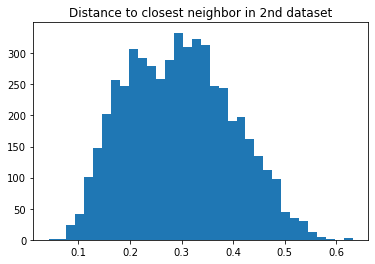

In [613]:

_ = plt.hist(neigh_distribution, bins='auto')  # arguments are passed to np.histogram
plt.title("Distance to closest neighbor in 2nd dataset")
plt.show()

Merge PCA projections

In [614]:
pca_list = []
n_pcs = 15

for i in range(len(files)):
    df= pd.read_csv(NMP_DIR + 'nmps_global_' + files[i]+'.csv', index_col =0)
    X = df.values
    pca_list.append(X[:,0:n_pcs])

In [615]:
pca_list[5].shape

(5248, 15)

### Run Aligned UMAP

Create list of dictionaries 

In [617]:
anchor_dict = []
# Parameter set 1: 
max_k = 10
frac_k = 0.05
max_dist = 0.05
use_metric = 'cosine'

# Parameter set 2: 
max_k = 20
frac_k = 0.05
max_dist = 0.05
use_metric = 'cosine'


for i in range(len(files)-1):
    Y = pca_list[i] # train on previous timepoint "progenitor space"
    X = pca_list[i+1] # for cells in next timepoint predict "progenitors"
    
    nbrs = NearestNeighbors(n_neighbors=1, #algorithm='ball_tree',
                           metric = use_metric).fit(Y)
    
    distances, indices = nbrs.kneighbors(X) # predict top progenitor for all cells
    
    neigh_distribution = np.concatenate(distances, axis = 0)
    neigh_indexes = np.concatenate(indices, axis =0)
    
    pairs = pd.DataFrame( {'neighbor':neigh_indexes ,'dist':neigh_distribution})
    pairs.reset_index(inplace = True)
    pairs.rename(columns ={'index':'cell_target'},inplace=True)
    
    # Grup by cell type (we'll find top anchors for each cell type)
    pairs['cell_type'] = meta_list[i+1].global_annotation.values
    df1 = pairs.groupby(['cell_type'])

    df2 = df1.apply(lambda x: x.sort_values(["dist"]))

    df3=df2.reset_index(drop=True)

    # keep the top neighbors for each cell type (NOTE some cells in t+1 will map to many cells in t)
    
    # For each progenitor in t keep only the cell in (t+1) with the smallest distance
    # Closest relative
    pairs_rank = df3.groupby('neighbor').head(1)
    
    #pairs_rank = df3.groupby('cell_type').head(max_k)
    
    # For each cell type we keep the top k prgenitor relations 
    pairs_rank = pairs_rank.groupby('cell_type').head(max_k)
    
    # filter any neighbor pair with distance larger than threshold
    pairs_rank = pairs_rank[pairs_rank['dist']<max_dist] 
    
    
    pairs_dict = {pairs_rank['neighbor'].values[j] :pairs_rank['cell_target'].values[j]  for j in range(pairs_rank.shape[0])}
    
    
    anchor_dict.append(pairs_dict)

In [618]:
len(pairs_dict)

218

In [619]:
[x.shape for x in meta_list]

[(585, 23), (3464, 23), (1748, 23), (2815, 23), (2191, 23), (5248, 23)]

In [620]:
[len(x) for x in anchor_dict]

[192, 199, 209, 202, 218]

In [621]:
[x.shape for x in pca_list]

[(585, 15), (3464, 15), (1748, 15), (2815, 15), (2191, 15), (5248, 15)]

In [622]:
aligned_mapper = umap.AlignedUMAP(  metric="cosine",
                                    n_neighbors=20,
                                    alignment_regularisation=0.01, # strength of the anchors across timepoints, default 0.1
                                    alignment_window_size=2, # how far forward and backward across the datasets we look when doing alignment, defaut 5
                                    n_epochs=200,
                                    random_state=42,).fit(pca_list, relations=anchor_dict)

In [645]:
all_timepoints = []
for i in range(0,len(files)):
    aligned_umap_coord = pd.DataFrame( {'UMAP_1':aligned_mapper.embeddings_[i].T[0], 'UMAP_2':aligned_mapper.embeddings_[i].T[1], 
               'timepoint' :files[i], 'cell_type':meta_list[i].global_annotation.values, 'cell_id' : meta_list[i].cell_id.values})
    all_timepoints.append(aligned_umap_coord)
    
umap_coords = pd.concat(all_timepoints)

In [646]:
palette_celltype = {'Neural_Posterior':'darkcyan',
                    'Neural_Crest': 'coral',
                    'Somites': 'slateblue',
                    'PSM':'darkviolet',
                    'Muscle': 'mediumorchid',
                    'Endoderm':'gray',
                    'Neural_Anterior': 'darkturquoise',
                    'Notochord':'rosybrown',
                    'NMPs':'gold',
                    'unassigned':'silver',
                    'Differentiating_Neurons':'lightseagreen',
                    'Epidermal':'linen',
                    'Adaxial_Cells': 'lightgray',
                    'Lateral_Mesoderm':'gray'}

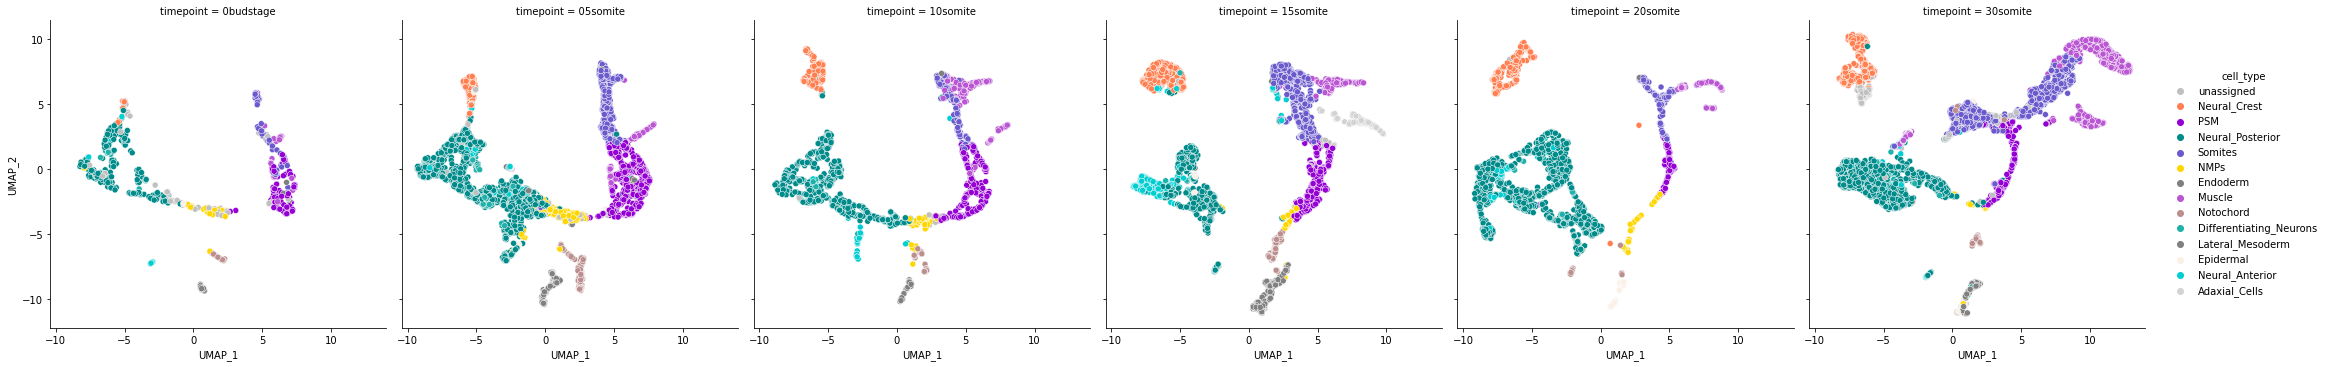

In [647]:
sns.relplot(
    data=umap_coords, x="UMAP_1", y="UMAP_2",
    col="timepoint", hue="cell_type",
    kind="scatter", palette = palette_celltype
)

In [648]:
umap_coords.head() 

,UMAP_1,UMAP_2,timepoint,cell_type,cell_id
0,-0.784364,-2.765818,0budstage,unassigned,TDR23_AAACGAATCCATCACC-1
1,-5.036266,5.124502,0budstage,Neural_Crest,TDR23_AACCCAACAGCGGTTC-1
2,7.108137,-2.566034,0budstage,PSM,TDR23_AATGAAGCATGTGGCC-1
3,-6.257589,1.244561,0budstage,Neural_Posterior,TDR23_AATGACCAGGAATCGC-1
4,-5.910647,0.755230,0budstage,Neural_Posterior,TDR23_ACAAAGATCGATTCCC-1


In [627]:
umap_coords.groupby(['timepoint']).size() 

timepoint
05somite     3464
0budstage     585
10somite     1748
15somite     2815
20somite     2191
30somite     5248
dtype: int64

Double check that number make sense (we should have all cells with new UMAP coordinates) 

In [628]:
[pca_list[i].shape for i in range(len(pca_list)) ]

[(585, 15), (3464, 15), (1748, 15), (2815, 15), (2191, 15), (5248, 15)]

In [629]:

# check which cell types in t+1 map to which cell types in t
data = list(anchor_dict[4].items())
an_array = np.array(data)

In [630]:
pairs = pd.DataFrame({'cell_type1':meta_list[4].global_annotation.values[an_array[:,0]], 'cell_type2':meta_list[5].global_annotation.values[an_array[:,1]]})
pairs.head(20)

,cell_type1,cell_type2
0,Neural_Anterior,Differentiating_Neurons
1,Differentiating_Neurons,Differentiating_Neurons
2,Differentiating_Neurons,Differentiating_Neurons
3,Differentiating_Neurons,Differentiating_Neurons
4,Neural_Posterior,Differentiating_Neurons
5,Neural_Anterior,Differentiating_Neurons
6,Differentiating_Neurons,Differentiating_Neurons
7,Neural_Posterior,Differentiating_Neurons
8,Neural_Posterior,Differentiating_Neurons
9,Neural_Anterior,Differentiating_Neurons


# Export aligned UMAPs 

Apr 14th 2022

* First subset those cells with aligned UMAP coordinates 
* Replace scanpy UMAP with aligned UMAP 
* Export h5ad into a different directory

In [649]:
import scanpy as sc
import os

In [685]:
NMP_DIR = '/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/nmps/timepoints/' # read Seurat UMAP objects from here 
NMP_DIR_ALIG = NMP_DIR + 'aligned_UMAP/'

data_path = NMP_DIR

data_folders = [f for f in os.listdir(data_path) if f.endswith('h5ad')]
display(data_folders)
data_folders.sort() 

['nmps_0budstage.h5ad',
 'nmps_05somite.h5ad',
 'nmps_10somite.h5ad',
 'nmps_15somite.h5ad',
 'nmps_30somite.h5ad',
 'nmps_20somite.h5ad']

In [705]:
for s in data_folders: 
    adata_aux = sc.read_h5ad(data_path + '/' + s)
    timepoint = adata_aux.obs.timepoint[0]
    
    timepoint = s.split("_")[1].split(".")[0]
    aligned_cells = umap_coords[umap_coords.timepoint==timepoint].cell_id

    adata_aux = adata_aux[aligned_cells,:].copy() 

    adata_aux.obsm['X_umap'] = umap_coords[umap_coords.timepoint==timepoint][['UMAP_1','UMAP_2']].values
    
    adata_aux.layers['counts'] = adata_aux.raw.X.copy() 
    del adata_aux.raw # we don't need this one
    adata_aux.write(NMP_DIR_ALIG  + 'nmps_' + timepoint + '.h5ad')
    
    
    #sc.pl.umap(adata_aux, color = 'global_annotation')

... storing 'orig.ident' as categorical
... storing 'X10X_run' as categorical
... storing 'fish' as categorical
... storing 'timepoint' as categorical
... storing 'cell_annotation' as categorical
... storing 'global_annotation' as categorical
... storing 'orig.ident' as categorical
... storing 'X10X_run' as categorical
... storing 'fish' as categorical
... storing 'timepoint' as categorical
... storing 'cell_annotation' as categorical
... storing 'global_annotation' as categorical
... storing 'orig.ident' as categorical
... storing 'X10X_run' as categorical
... storing 'fish' as categorical
... storing 'timepoint' as categorical
... storing 'cell_annotation' as categorical
... storing 'global_annotation' as categorical
... storing 'orig.ident' as categorical
... storing 'X10X_run' as categorical
... storing 'fish' as categorical
... storing 'timepoint' as categorical
... storing 'cell_annotation' as categorical
... storing 'global_annotation' as categorical
... storing 'orig.ident' as 

'30somite'